# Tarea Dask, 207480, Eduardo Garcia

## Instrucciones generales
- Esta tarea debe realizarse de manera individual
- Este notebook (resuelto) debe ser subido al github del proyecto en la carpeta de tareas (creen una carpeta dentro de esa carpeta y agreguen su notebook reuelto)
- Fecha límite: Lunes 25 de noviembre de 2024 a las 11:59 p.m
- Deben realizar las cuatro secciones
- Puedes agregar tantas celdas de código y explicaciones como veas necesario, solo manten la estructura general

## Sección 0 Creación y Configuración del cliente de Dask
Ejercicio 0: Configuración del cliente
1. Crea un cliente local de Dask que inicie un clúster en tu máquina.
2. Configura el cliente para que tenga las siguientes características (elige un par de las opciones de trabajadores e hilos):
    - Número de trabajadores: 2 / 4
    - Memoria máxima por trabajador: 1GB
    - Threads por trabajador: 4 / 2
3. Verifica que el cliente esté funcionando correctamente mostrando:
    - Resumen de los trabajadores activos.
    - Dashboard disponible (URL del panel de control de Dask).
    * Tip: Checa los parámetros del cliente que creeaste.

*Nota*: Puedes hacer que corra en el puerto que desees.

In [1]:
#Importamos todo
import dask
from dask.distributed import Client, as_completed
import dask.array as da
import dask.dataframe as dd
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

In [2]:
# Crear cliente Dask con configuraciones específicas
client = Client(
    n_workers=2,           # 2 trabajadores 
    threads_per_worker=4,  # 4 hilos por trabajador
    memory_limit='1GB',    # Límite de memoria por trabajador
    dashboard_address=':8882'  # Puerto específico para el dashboard
)

# Mostrar información del cliente
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8882/status,
Dashboard: http://127.0.0.1:8882/status,Workers: 2
Total threads: 8,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36227,Workers: 2
Dashboard: http://127.0.0.1:8882/status,Total threads: 8
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:45243,Total threads: 4
Dashboard: http://127.0.0.1:38271/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:36223,


## Sección 1 Delayed
Ejercicio 1: Procesamiento de datos 

1. Genera datos simulados (por ejemplo, ventas diarias) para 10 sucursales durante 365 días.
    - Cada sucursal debe tener datos generados aleatoriamente para "Ingresos" y "Costos".
    - Utiliza una función para generar los datos simulados.
2. Usa Dask Delayed para calcular:
    - Las ganancias diarias por sucursal.
    - La sucursal con mayor ganancia promedio.
3. Genera un grafo de tareas que visualice estas operaciones y explica por qué elegiste paralelizar de esa forma, genera una visualización del grafo.

Resultados:
Sucursal con mayor ganancia promedio: 1
Ganancia promedio: $313.13


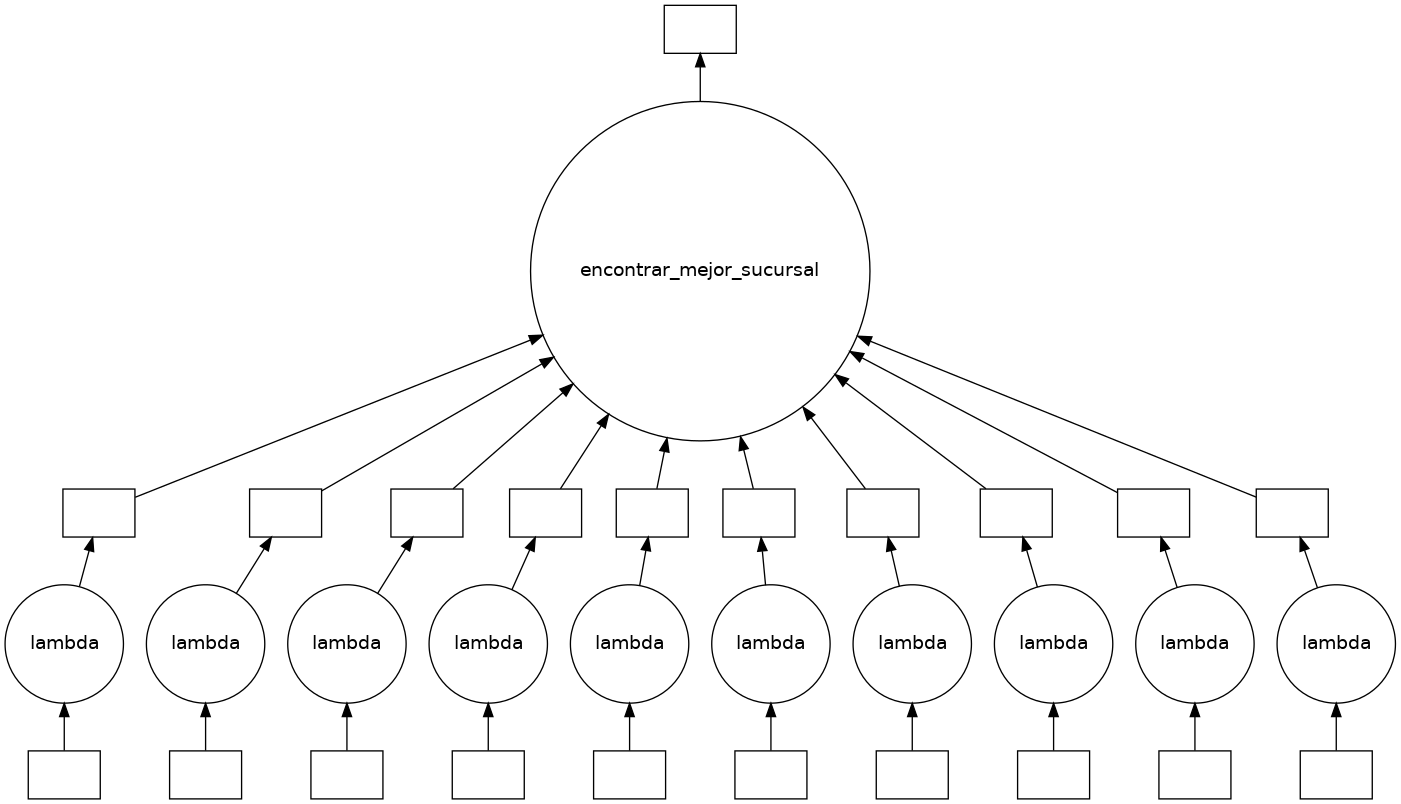

In [3]:
# Configuración de semilla para reproducibilidad
np.random.seed(42)

# Generar datos simulados para 10 sucursales
sucursales_datos = []
for id_sucursal in range(10):
    # Generar fechas para 365 días
    fechas = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(365)]
    
    # Generar ingresos y costos aleatorios
    ingresos = np.random.normal(1000, 200, 365)
    costos = np.random.normal(700, 150, 365)
    
    # Crear DataFrame
    df = pd.DataFrame({
        'fecha': fechas,
        'sucursal': id_sucursal,
        'ingresos': ingresos,
        'costos': costos
    })
    
    # Aplicar Dask Delayed
    sucursal_delayed = dask.delayed(df)
    sucursales_datos.append(sucursal_delayed)

# Calcular ganancias para cada sucursal
ganancias_sucursales = []
for sucursal_data in sucursales_datos:
    ganancias = dask.delayed(lambda df: df.assign(ganancias=df['ingresos'] - df['costos']))(sucursal_data)
    ganancias_sucursales.append(ganancias)

# Encontrar la sucursal con mayor ganancia promedio
@dask.delayed
def encontrar_mejor_sucursal(dataframes):
    # Concatenar todos los DataFrames
    datos_completos = pd.concat(dataframes)
    
    # Calcular ganancias promedio por sucursal
    ganancias_por_sucursal = datos_completos.groupby('sucursal')['ganancias'].mean()
    
    # Encontrar la sucursal con mayor ganancia
    mejor_sucursal = ganancias_por_sucursal.idxmax()
    ganancia_maxima = ganancias_por_sucursal.max()
    
    return mejor_sucursal, ganancia_maxima

# Computar resultados
mejor_sucursal = encontrar_mejor_sucursal(ganancias_sucursales)
resultado = mejor_sucursal.compute()

print("Resultados:")
print(f"Sucursal con mayor ganancia promedio: {resultado[0]}")
print(f"Ganancia promedio: ${resultado[1]:.2f}")

# Visualizar grafo de tareas

mejor_sucursal.visualize()

### Paralelize asi para calcular las ganancias de cada sucursal de manera independiente, por ejemplo la de la sucursal 1 mientras hago la de la 2, lo cual agiliza el calculo. Y distribuimos asi los trabajos entre los workers.

## Sección 2 Dask Dataframes
Ejercicio 2: Limpieza y análisis de datos reales

1. Descarga un conjunto de datos masivo (puedes usar la colección de *nycflights* que se encuentra en `data/nycflights/`).
2. Carga los datos en un Dask DataFrame. 
    - Elige adecuadamente el número de particiones (que quepan en memoria de los `workers`)
3. Realiza las siguientes tareas:
    - Limpia los valores faltantes en las columnas `ArrDelay` y `DepDelay`, rellenándolos con la mediana de cada columna.
    - Calcula el retraso promedio (`DepDelay`) por mes y aerolínea.
    - Encuentra el aeropuerto de origen con más vuelos retrasados.

*Nota*: **Evita** convertir el DataFrame a pandas e **intenta** realizar `.compute()` solo cuando sea necesario.

In [4]:
"""Procesa el conjunto de datos de vuelos."""
# Cargar datos
df = dd.read_csv("data/nycflights/*.csv")

# Limpiar valores faltantes
arr_median = df.ArrDelay.median_approximate()
dep_median = df.DepDelay.median_approximate()

df['ArrDelay'] = df.ArrDelay.fillna(arr_median)
df['DepDelay'] = df.DepDelay.fillna(dep_median)

# Calcular retraso promedio por mes y aerolínea
delays_by_month = df.groupby(['Month', 'UniqueCarrier'])['DepDelay'].mean()

# Encontrar aeropuerto con más vuelos retrasados
delayed_flights = df[df.DepDelay > 0].groupby('Origin').size()
worst_airport = delayed_flights.compute().idxmax()

print("Retraso promedio por mes y aerolínea:")
print(delays_by_month.compute())
print("\nAeropuerto con más vuelos retrasados:", worst_airport)


Retraso promedio por mes y aerolínea:
Month  UniqueCarrier
1      AA                8.963504
       CO               11.693346
       DL                9.249338
       EA               24.258191
       HP               18.697144
                          ...    
6      ML (1)            3.364372
7      ML (1)            4.964143
8      ML (1)            9.478431
9      ML (1)            2.583673
10     ML (1)            4.493976
Name: DepDelay, Length: 130, dtype: float64

Aeropuerto con más vuelos retrasados: EWR


## Sección 3 Dask Arrays

Ejercicio 3: Procesamiento numérico avanzado

1. Crea un arreglo de 10,000 x 10,000 con valores aleatorios usando Dask Array, utiliza un tamaño de chunks adecuado, ¿es mejor que sean cuadrados?.
2. Realiza las siguientes operaciones:
    - Calcula la suma de cada fila.
    - Encuentra la fila con el valor máximo promedio.
    - Multiplica todo el arreglo por un factor escalar (por ejemplo, 2.5).
3. Divide el arreglo nuevamente en 100 bloques y compara la rapidez.

In [7]:
# Crear un array grande con chunks
arr = da.random.random((10000, 10000), chunks=(1000, 1000))

# Operaciones con el array original
start_time = time.time()
row_sums = arr.sum(axis=1)
row_means = arr.mean(axis=1)
max_row_idx = row_means.argmax()
scaled_arr_mean = (arr * 8).mean()

# Computear todo junto para el array original
results_original = da.compute(row_sums, row_means, max_row_idx, scaled_arr_mean)
time_original = time.time() - start_time

# Redividir en 100 bloques
new_chunks = (arr.shape[0] // 10, arr.shape[1] // 10)
repartitioned_arr = arr.rechunk(new_chunks)

# Operaciones con el array reparticionado
start_time = time.time()
re_row_sums = repartitioned_arr.sum(axis=1)
re_row_means = repartitioned_arr.mean(axis=1)
re_max_row_idx = re_row_means.argmax()
re_scaled_arr_mean = (repartitioned_arr * 8).mean()

# Computear todo junto para el array reparticionado
results_repartitioned = da.compute(re_row_sums, re_row_means, re_max_row_idx, re_scaled_arr_mean)
time_repartitioned = time.time() - start_time

# Desempaquetar resultados
row_sums, row_means, max_row_idx, scaled_arr_mean = results_original
re_row_sums, re_row_means, re_max_row_idx, re_scaled_arr_mean = results_repartitioned

# Imprimir resultados y tiempos
print("Resultados:")
print(f"Suma de cada fila (original): {row_sums[:5]}...")  # Muestra solo las primeras 5 para legibilidad
print(f"Índice de la fila con mayor valor promedio (original): {max_row_idx}")
print(f"Media del array escalado (original): {scaled_arr_mean}")
print(f"Tiempo con array original: {time_original:.2f} segundos")

print(f"\nSuma de cada fila (reparticionado): {re_row_sums[:5]}...")
print(f"Índice de la fila con mayor valor promedio (reparticionado): {re_max_row_idx}")
print(f"Media del array escalado (reparticionado): {re_scaled_arr_mean}")
print(f"Tiempo con array reparticionado: {time_repartitioned:.2f} segundos")


Resultados:
Suma de cada fila (original): [4958.6688098  5007.65967552 5027.92208127 5039.25293612 4985.25236423]...
Índice de la fila con mayor valor promedio (original): 402
Media del array escalado (original): 3.999956033334699
Tiempo con array original: 2.34 segundos

Suma de cada fila (reparticionado): [4958.6688098  5007.65967552 5027.92208127 5039.25293612 4985.25236423]...
Índice de la fila con mayor valor promedio (reparticionado): 402
Media del array escalado (reparticionado): 3.999956033334699
Tiempo con array reparticionado: 2.02 segundos


Sí, en la mayoría de los casos, es mejor que los chunks sean cuadrados. 
Por que:
Dask distribuye cada chunk como una unidad de trabajo a los workers.
Con chunks cuadrados (por ejemplo, 1000 x 1000), las tareas se dividen de manera uniforme en ambas dimensiones, lo que balancea mejor la carga entre los workers.

## Sección 4 Futures
Ejercicio 4: Distribución de tareas dinámicas

1. Implementa una función que calcule la raíz cuadrada de una lista de 100,000 números enteros generados aleatoriamente.
2. Divide la lista en 10 partes iguales y usa Dask Futures para calcular la raíz cuadrada de cada parte en paralelo.
3. Recolecta los resultados y calcula:
    - El promedio de todos los números procesados.
    - El tiempo total de ejecución (incluyendo envío y recolección de tareas).
4. Observa como se distribuye la carga en el cliente.

*Nota*: en los ejercicios ya vimos como determinar si ya se cumplío una tarea.

In [ ]:
# Función para calcular la raíz cuadrada
def calculate_sqrt(numbers):
    return np.sqrt(numbers)

# 1. Generar una lista de 100,000 números enteros aleatorios
n_numbers = 100000
data = np.random.randint(1, 1000, size=n_numbers)

# 2. Dividir la lista en 10 partes iguales
n_parts = 10
split_data = np.array_split(data, n_parts)

# 3. Enviar tareas al clúster usando Futures
start_time = time.perf_counter()
futures = [client.submit(calculate_sqrt, part) for part in split_data]

# 4. Recolectar los resultados a medida que se completan
results = []
for future in as_completed(futures):
    results.append(future.result())

# 5. Calcular el promedio de todos los números procesados
all_results = np.concatenate(results)  # Combina todas las partes
mean_result = np.mean(all_results)

# 6. Medir el tiempo total de ejecución
total_time = time.perf_counter() - start_time

# Imprimir resultados
print(f"Promedio de los números procesados: {mean_result:.2f}")
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")
print(f"Total de tareas completadas: {len(results)}")

Promedio de los números procesados: 21.07
Tiempo total de ejecución: 0.17 segundos
Total de tareas completadas: 10
